# LAB6 QIC

In [1]:
!pip install qiskit qiskit-aer qiskit-terra seaborn numpy matplotlib pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.4 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 9.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 10.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [34]:
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import IBMQ
import math
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np



## Superdense Coding

Superdense Coding and Quantum Teleportation are closely related. Quantum teleportation is the process in which the state of the qubit $\ket{\psi}$ can be transmitted from one location to another, using two bits of classical communication and a Bell pair. It's a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding, on the other hand, is a procedure to send two classical bits to another location using just a single qubit of communication.

### The procedure

#### Step 1

The process is started by a third party, Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $\ket{0}$, on which he apply the Hadamard gate on the first qubit and CNOT gate (first qubit is the control qubit). 

$\ket{00} = \ket{0}_A \otimes \ket{0}_B$

After applying the H gate we obtain the state:

$$
\ket{+0}=\frac{1}{\sqrt{2}}\left(\ket{00}+\ket{10}\right)
$$

After applying the CNOT gate results the state:

$$
CNOT: \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{10}\right) \rightarrow \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)
$$

#### Step 2

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send

| Intended Message | Applied Gate | Resulting State ($ \frac{1}{\sqrt{2}}$) |
|------------------|--------------|---------------------------------------------|
| 00               | I            | $\ket{00}+\ket{11}$                         |
| 01               | X            | $\ket{10}+\ket{01}$                         |
| 10               | Z            | $\ket{00}-\ket{11}$                         |
| 11               | ZX           | $-\ket{10}+\ket{01}$                        |

#### Step 3

Bob receives Alice's qubit and uses his qubit to decode Alice's message. Bob applies CNOT gate using leftmost qubit as control and rightmost as target. Then he applies H gate and finally performs a measurement on both qubits to extract Alice's message.

| Bob Receives ($ \frac{1}{\sqrt{2}}$)        | After CNOT gate ($ \frac{1}{\sqrt{2}}$) | After H-gate |
|---------------------------------------------|-----------------------------------------|--------------|
| $\ket{00}+\ket{11}$                         | $\ket{00}+\ket{01}$                     | $\ket{00}$   |
| $\ket{10}+\ket{01}$                         | $\ket{11}+\ket{01}$                     | $\ket{01}$   |
| $\ket{00}-\ket{11}$                         | $\ket{00}-\ket{10}$                     | $\ket{10}$   |
| $-\ket{10}+\ket{01}$                        | $-\ket{11}+\ket{01}$                    | $\ket{11}$   |

### Qiskit Implementation

In [4]:
# function to create a bell pair
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1,0)
    return qc

In [5]:
# function to encode message
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc
    

In [6]:
# function to decode message
def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

In [7]:
# Step 1, Charlie creates the Bell pair
qc = create_bell_pair()

/opt/conda/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


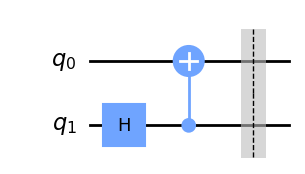

In [8]:
qc.barrier()
qc.draw(output = "mpl")

In [9]:
# Qubit 0 goes to Alice and 1 goes to Bob
# Alice encodes her message on 1 qubit.
message = "10"
qc = encode_message(qc, 1, message)

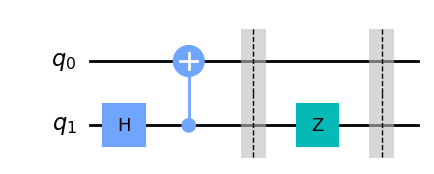

In [10]:
qc.barrier()
qc.draw(output = "mpl")

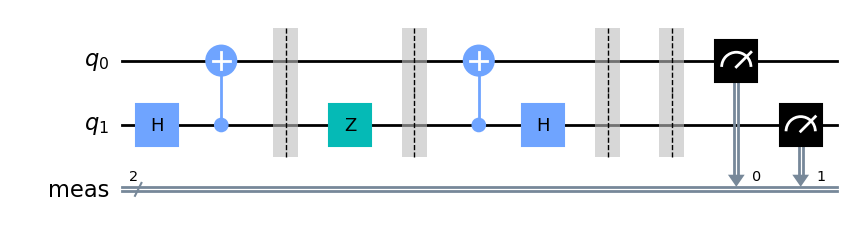

In [11]:
# Alice send her qubit to Bob.
# Bob applies the recovery protocol:
qc = decode_message(qc)
qc.barrier()
qc.measure_all()
qc.draw(output = "mpl")

{'10': 1024}


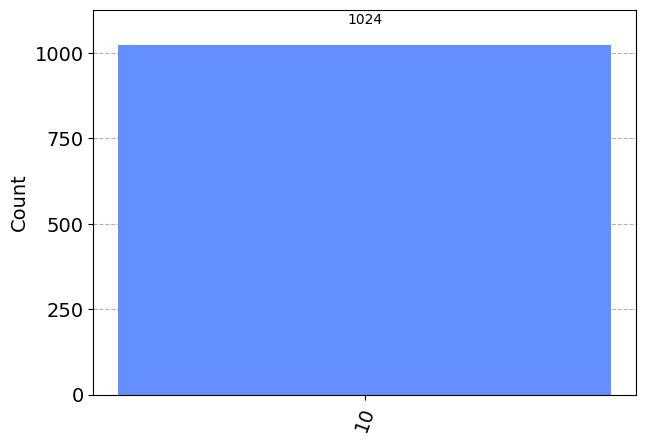

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(qc).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [118]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.save_account("<token>")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

configrc.store_credentials:WARNING:2023-11-17 12:12:50,190: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-11-17 12:12:50,506: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_nairobi


In [119]:
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

In [ ]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

In [ ]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

In [ ]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

## Quantum Teleportation

Suppose that Alice wants to send quantum information to Bob. Specifically, she wants to send the qubit state $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$, meaning passing on information about $\alpha$ and $\beta$ to Bob.

Since quantum mechanics forbids creating an exact copy of an unknown quantum state (no-cloning theorem), Alice cannot simply generate a copy of $\ket{\psi}$ and give it to Bob. However, the only solution is to take advantage of 2 classical bits and an entangled state to transfer the $\ket{\psi}$ state. Basically, Alice will transfer her state to Bob, and at the end Bob will have $\ket{\psi}$ and Alice won't have the state anymore.

### Quantum Teleportation Protocol

#### Overview

To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

In [58]:
## Setup
qr= QuantumRegister(3, name="q")
crz,crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr,crz,crx)

##### Step 1

The third party, Telamon, creates an entangled pair of qubits (a Bell pair) and gives one to Bob and one to Alice. Alice owns $q_1$ and Bob owns $q_2$.

In [59]:
def create_bell_pair(qc, a, b):
    """ Creates a Bell pair in qc using qubits a and b"""
    qc.h(a)
    qc.cx(a,b)

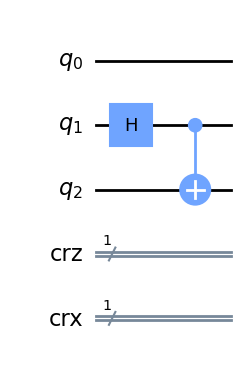

In [60]:
## Step 1
create_bell_pair(teleportation_circuit,1,2)
teleportation_circuit.draw(output="mpl")

##### Step 2

Alice applies CNOT gate on $q_1$, controlled by $\ket{\psi}$ (the qubit she is trying to send Bob). After that, she applies a Hadamard gate to $\ket{\psi}$. In our circuit, $\ket{\psi}$ is $q_0$.

In [61]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

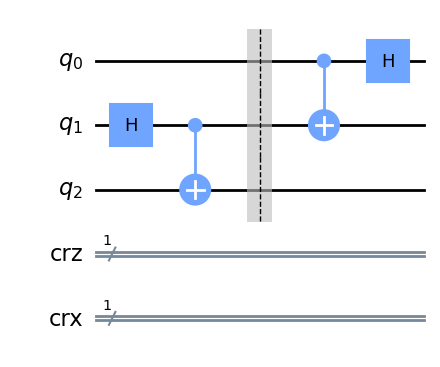

In [62]:
## Step 2

teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output="mpl")

##### Step 3

Alice applies a measurement to both qubits that she owns ( $q_1$ and $\ket{\psi}$) and stores the result in 2 classical bits. She send these two bits to Bob.

In [63]:
def measure_and_send(qc,a,b):
    qc.measure(a,0)
    qc.measure(b,1)

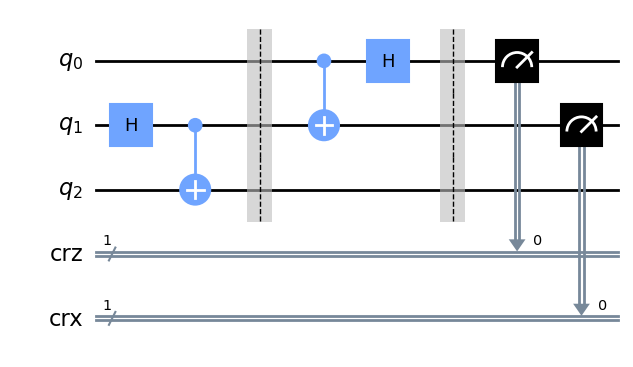

In [64]:
teleportation_circuit.barrier()
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output="mpl")

##### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply X gate

10 $\rightarrow$ Apply Z gate

11 $\rightarrow$ Apply ZX gate


In [65]:
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

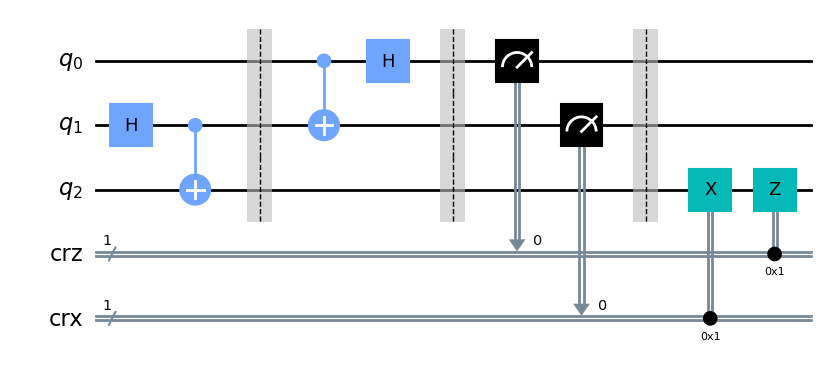

In [66]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw(output="mpl")

#### Simulating the Teleportation Protocol

We will initialize Alice's qubit in a random state $\ket{\psi}$ suing an *Initialize* gate on $\ket{q_0}$. 

In [67]:
# Create random 1-qubit state
psi = random_statevector(2)

<IPython.core.display.Latex object>

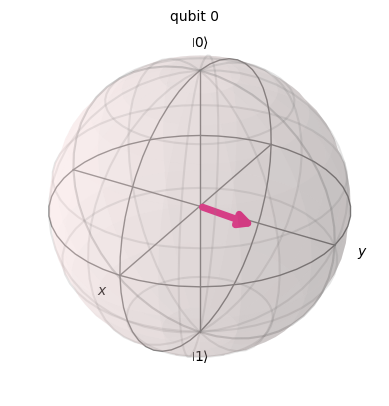

In [68]:
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [69]:
init_gate = Initialize(psi)
init_gate.label = "init"

In [70]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)



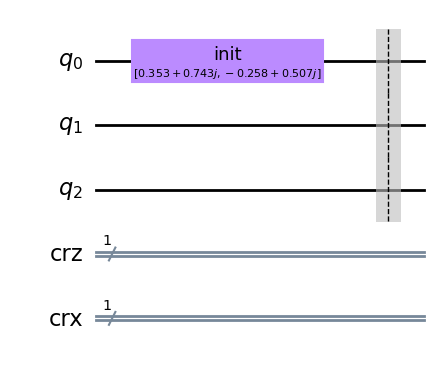

In [71]:
## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()
qc.draw(output="mpl")

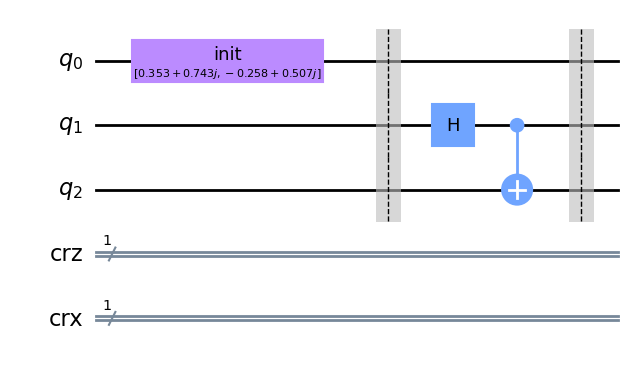

In [72]:
## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
qc.draw(output="mpl")


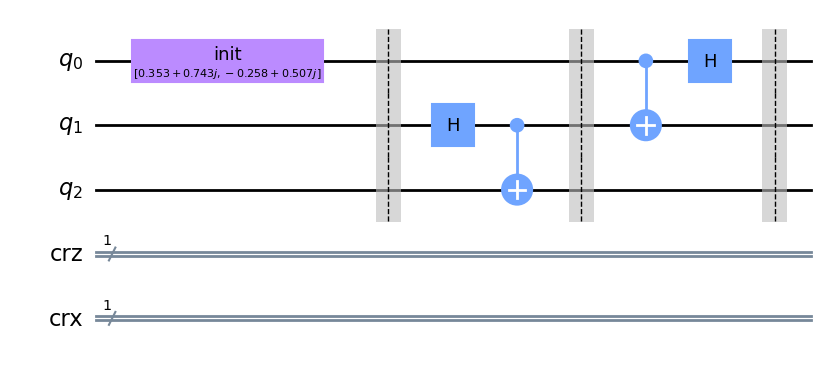

In [73]:
## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
qc.draw(output="mpl")

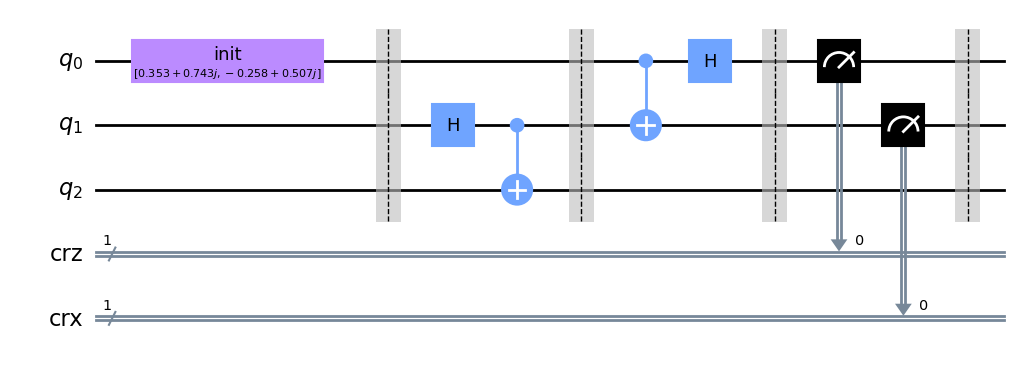

In [74]:
## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)
qc.barrier()
qc.draw(output="mpl")

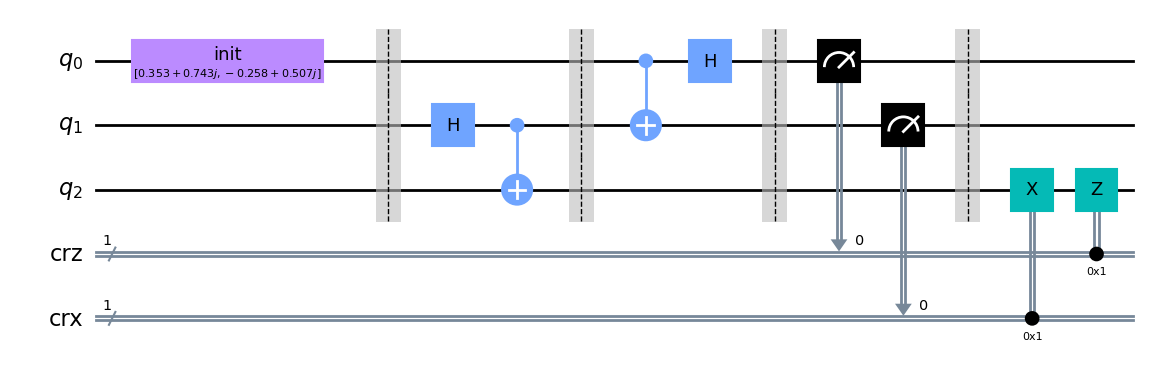

In [75]:
## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw(output="mpl")

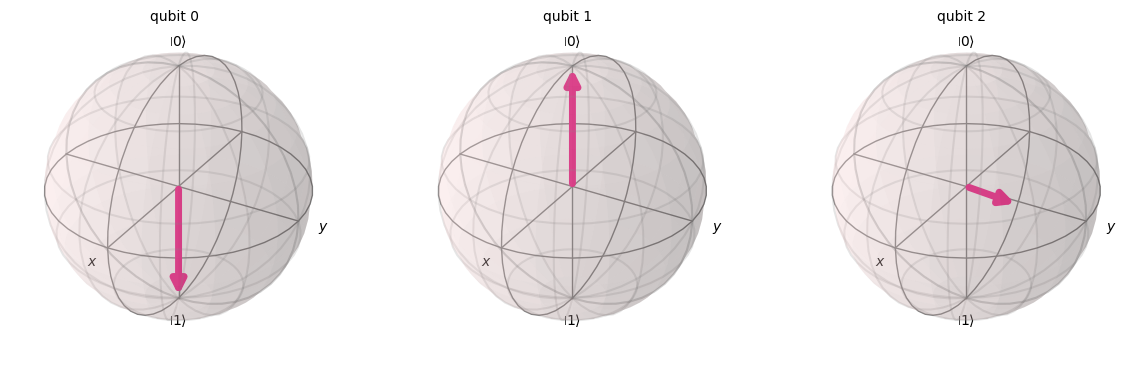

In [76]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

#### Mathematical formalism

##### Step 1

The entangled qubit prepared by Telamon is $\ket{e} = \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)$.

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively): $\ket{e} = \frac{1}{\sqrt{2}}\left(\ket{0}_A\ket{0}_B+\ket{1}_A\ket{1}_B\right)$. Thus, it creates a 3 qubit quantum system where Alice possess the first two qubits and Bob the last one:

$$
\ket{\psi}\otimes\ket{e}=\frac{1}{\sqrt{2}}\left(\alpha\ket{0}\otimes\left(\ket{00}+\ket{11}\right) + \beta\ket{1}\otimes\left(\ket{00}+\ket{11}\right)\right)=\frac{1}{\sqrt{2}}\left(\alpha\ket{000}+\alpha\ket{011}+\beta\ket{100}+\beta\ket{111}\right)
$$

##### Step 2

Alice applies CNOT gate on her 2 qubits followed by Hadamard on the first qubit, resulting the state:

$$
\left(H\otimes I\otimes I\right)\left(CNOT\otimes I\right)\left(\ket{\psi}\otimes\ket{e}\right) = \left(H\otimes I\otimes I\right)\left(CNOT\otimes I\right)\frac{1}{\sqrt{2}}\left(\alpha\ket{000}+\alpha\ket{011}+\beta\ket{100}+\beta\ket{111}\right) = \left(H\otimes I\otimes I\right)\frac{1}{\sqrt{2}}\left(\alpha\ket{000}+\alpha\ket{011}+\beta\ket{110}+\beta\ket{101}\right)=\frac{1}{2}\left(\alpha\left(\ket{000}+\ket{011}+\ket{100}+\ket{111}\right)+\beta\left(\ket{010}+\ket{001}-\ket{110}-\ket{101}\right)\right)
$$

Which can be written as:
$$
=\frac{1}{2}\left(\ket{00}\left(\alpha\ket{0}+\beta\ket{1}\right)+\ket{01}\left(\alpha\ket{1}+\beta\ket{0}\right)+\ket{10}\left(\alpha\ket{0}-\beta\ket{1}\right)+\ket{11}\left(\alpha\ket{1}-\beta\ket{0}\right)\right)
$$

##### Step 3

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states $\ket{00}$, $\ket{01}$, $\ket{10}$, and $\ket{11}$ with equal probability.

On the basis of her measurement, Bob's state will be projected tow:
$$
\ket{00} \rightarrow \left(\alpha\ket{0}+\beta\ket{1}\right)
$$

$$
\ket{01} \rightarrow \left(\alpha\ket{1}+\beta\ket{0}\right)
$$

$$
\ket{10} \rightarrow \left(\alpha\ket{0}-\beta\ket{1}\right)
$$

$$
\ket{11} \rightarrow \left(\alpha\ket{1}-\beta\ket{0}\right)
$$

##### Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $\ket{\psi}$ by applying appropriate transformations on his qubit that was once part of the entangled pair. The transformation he needs to apply are:

| Bob's state | Bits received | Gate Applied |
|-------------|---------------|--------------|
|$\left(\alpha\ket{0}+\beta\ket{1}\right)$ | $00$ | *I* |
|$\left(\alpha\ket{1}+\beta\ket{0}\right)$ | $01$ | *X* |
|$\left(\alpha\ket{0}-\beta\ket{1}\right)$ | $10$ | *Z* |
|$\left(\alpha\ket{1}-\beta\ket{0}\right)$ | $11$ | *ZX* |

#### Quantum Teleportation on a real Quantum Computer

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Due to the *deferred measuremenent principle* (states that any measurement can be posponed until the end of the circuit) we can move all the measurements to the end, and we get the same results.

In [86]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)


/opt/conda/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


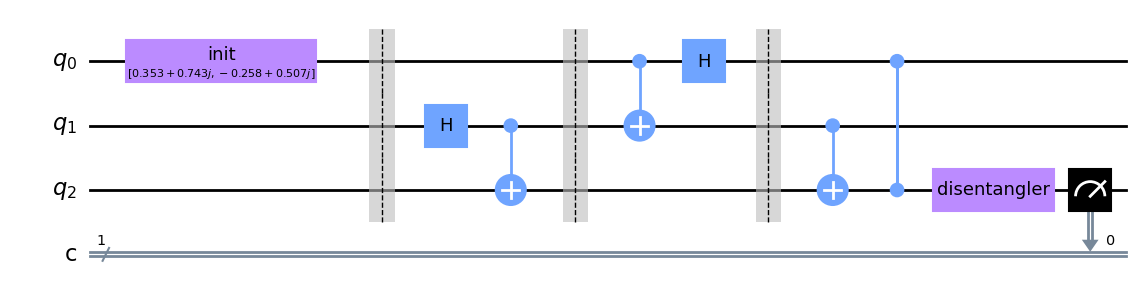

In [87]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw(output = "mpl")

In [ ]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [ ]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

In [ ]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)